### What am I doing here and what do the results mean? 

What I am doing: What I am doing here is checking how the variable "allowed" (does your husband allow you to work?) impacts the Probability that the woman works. Now since the value for allowed var is only available for women that are not working, I assume that p = 1/2 the women who are working are not allowed. It turns out, in the last cell, the coefficient on allowed (y=employed) is -0.2. It is 20\% less likely that a woman works when her husband allows her. So then there must be something up with the assumption of p = 1/2.
Maybe allocated p = p* to North and p = 1-p* to the south. Then see how the answer changes with p*.
THE RESULTS DUE TO p = 1/2 give me this weird relationship between "allowed" and Employed -- and in my meeting with Kennan, I mistakenly said that North allowed less women to work and had more women working. This was All India result -- the negative relation between allowed and Employed.


6th Oct: I see that the relationship between Allowed to Work and Woman Working is what we would expect only if P(Allowed|Working = 1) > 0.6. 

In [2]:
import pandas as pd
import numpy as np
import os
import copy
import scipy.stats as stats
import math
from scipy.optimize import minimize
from scipy.optimize import Bounds
from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
df = pd.read_stata("../../data/raw/ICPSR_36151/DS0003/36151-0003-Data.dta")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/raw/ICPSR_36151/DS0003/36151-0003-Data.dta'

In [ ]:
df.columns

In [ ]:
df.STATE

In [5]:
df.loc[:,"working"] = 0
df.loc[df["GR46B"] == "Yes 1", "working"] = 1
df.loc[df["GR46A"] == "No 0", "working"] = 0

C:\Users\shrey\AppData\Local\Temp\ipykernel_5652\2526965417.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:,"working"] = 0


In [6]:
df.loc[:,"north"] = None
df.loc[df["STATEID"].apply(lambda x: int(x[-2:])).isin([24, 8, 9, 5, 3, 22, 23, 7, 6]), "north"] = 1
df.loc[df["STATEID"].apply(lambda x: int(x[-2:])).isin([32, 33, 29, 28, 27]), "north"] = 0
# replace north = 1 if inlist(STATEID, 24, 8, 9, 23, 7, 6)
# replace north = 0 if inlist(STATEID, 32, 33, 29, 28, 27)

C:\Users\shrey\AppData\Local\Temp\ipykernel_5652\3967789098.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:,"north"] = None


In [7]:
# Create allowed variable in the end. 
# Get other things first. 
df_reg = copy.deepcopy(df)
df_reg = df_reg[(df_reg["north"] == 1) | (df_reg["north"] == 0)]

P = np.linspace(0,1,20)
df_estimates = pd.DataFrame()
est = []
err = []


for p in P:    
    df_reg["allowed"] = None
    df_reg.loc[df_reg["GR49"] == "No 0", "allowed"] = 0
    df_reg.loc[df_reg["GR49"] == "Yes 1", "allowed"] = 1
    
    bit_arr = np.random.uniform(0,1,df_reg.loc[df_reg["GR49"].isna(),:].shape[0]) < p
    int_arr = [int(b) for b in bit_arr]
    df_reg.loc[df_reg["GR49"].isna(),"allowed"] = int_arr
    X = df_reg["allowed"].astype(float)
    X = sm.add_constant(X)
    y = df_reg["working"].astype(float)
    model = sm.OLS(y, X).fit()
    e = model.params["allowed"]
    gap = model.conf_int().loc["allowed"][1] - model.params["allowed"]
    est.append(e)
    err.append(gap)


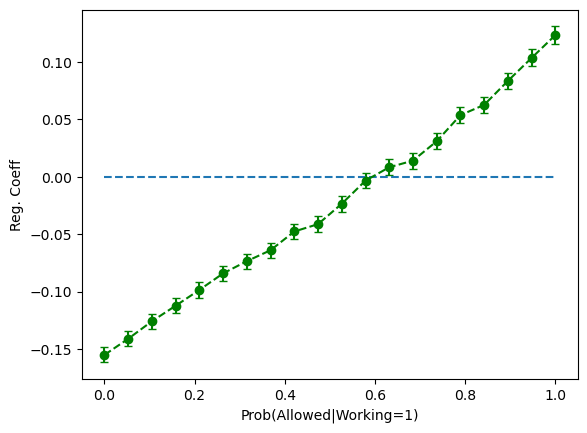

In [8]:
plt.errorbar(x=P, y=est, yerr=err, capsize=3, fmt='g--o')
plt.hlines(y=0.0, xmin=-0.0, xmax=1.0, linestyles="--")
plt.xlabel('Prob(Allowed|Working=1)')
plt.ylabel('Reg. Coeff')
# plt.legend()
plt.show()

Assume p = 0.8; How does North and South compare then? That is, do I see that North does not allow women to work more than the South?

In the above structure, it is assumed that P(Allowed|Working=1) is the same in North vs. the South. What if they are not? 
Assume P(Allowed|working = 1, north = 1) = p*, P(Allowed|working = 1, south = 1) = 1-p*.

In [9]:
df_reg = copy.deepcopy(df)
df_reg = df_reg[(df_reg["north"] == 1) | (df_reg["north"] == 0)]

P = np.linspace(0.01,0.99,20)
df_estimates = pd.DataFrame()
est = []
err = []


for p in P:    
    df_reg["allowed"] = None
    df_reg.loc[df_reg["GR49"] == "No 0", "allowed"] = 0
    df_reg.loc[df_reg["GR49"] == "Yes 1", "allowed"] = 1

    bit_arr_north = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),:].shape[0]) < p
    bit_arr_south = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),:].shape[0]) < 1-p
    int_arr_north = [int(b) for b in bit_arr_north]
    int_arr_south = [int(b) for b in bit_arr_south]
    df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),"allowed"] = int_arr_north
    df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),"allowed"] = int_arr_south
    X = df_reg["allowed"].astype(float)
    X = sm.add_constant(X)
    y = df_reg["working"].astype(float)
    model = sm.OLS(y, X).fit()
    e = model.params["allowed"]
    gap = model.conf_int().loc["allowed"][1] - model.params["allowed"]
    est.append(e)
    err.append(gap)


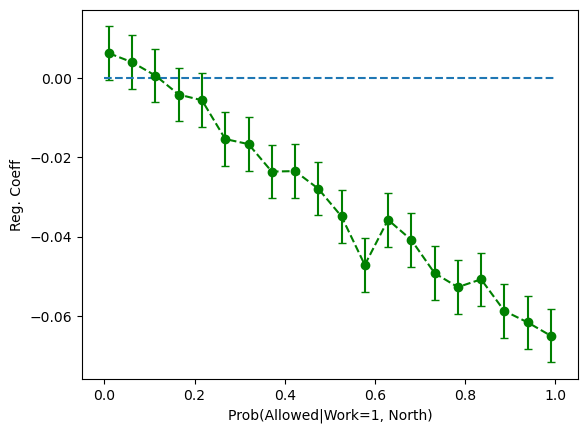

In [10]:
plt.errorbar(x=P, y=est, yerr=err, capsize=3, fmt='g--o')
plt.hlines(y=0.0, xmin=-0.0, xmax=1.0, linestyles="--")
plt.xlabel('Prob(Allowed|Work=1, North)')
plt.ylabel('Reg. Coeff')
# plt.legend()
plt.show()

### Final Comments

The assumptions taken for P(Allowed|Working=1) proves critical. In the first chart, I assume P(Allowed|Working=1) is independent of North/South. That gives me a positive relationship between P(Allowed|Working=1) and the regression coefficient of `working` on `allowed` variable. 

Assuming some dependence of P(Allowed|Working=1), such as I did in the second figure, where I assume North and South to behave opposite to each other in allowing women to work, the relationship turns on its head. 

The first suggest, I would need P(Allowed|Working=1) > 0.6 to have a meaningful (+ve) relationship between `working` and `allowed` while the second suggests, P(Allowed|Working=1, north=1) < 0.1, P(Allowed|Working=1, north=0) > 0.9 is needed. 

I try more models for possible behaviours of P(Allowed|Working=1, north), and I get very different ranges of `p` that would be acceptable. 

In [11]:
df_reg = copy.deepcopy(df)
df_reg = df_reg[(df_reg["north"] == 1) | (df_reg["north"] == 0)]

P = np.linspace(0.01,0.50,10)
df_estimates = pd.DataFrame()
est = []
err = []


for p in P:    
    df_reg["allowed"] = None
    df_reg.loc[df_reg["GR49"] == "No 0", "allowed"] = 0
    df_reg.loc[df_reg["GR49"] == "Yes 1", "allowed"] = 1

    bit_arr_north = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),:].shape[0]) <= 0.5-p
    bit_arr_south = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),:].shape[0]) <= 0.5+p
    int_arr_north = [int(b) for b in bit_arr_north]
    int_arr_south = [int(b) for b in bit_arr_south]
    df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),"allowed"] = int_arr_north
    df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),"allowed"] = int_arr_south
    X = df_reg["allowed"].astype(float)
    X = sm.add_constant(X)
    y = df_reg["working"].astype(float)
    model = sm.OLS(y, X).fit()
    e = model.params["allowed"]
    gap = model.conf_int().loc["allowed"][1] - model.params["allowed"]
    est.append(e)
    err.append(gap)


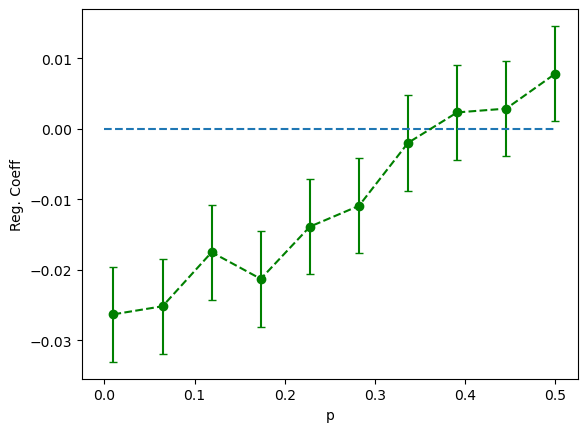

In [12]:
plt.errorbar(x=P, y=est, yerr=err, capsize=3, fmt='g--o')
plt.hlines(y=0.0, xmin=-0.0, xmax=0.5, linestyles="--")
plt.xlabel('p')
plt.ylabel('Reg. Coeff')
# plt.legend()
plt.show()

In [ ]:
Est = [0]*20
Err = [0]*20
for i in range(10):
    Est = [x+y for x,y in zip(Est, est[i])]
    Err = [x+y for x,y in zip(Err, err[i])]
Est = [e/10 for e in Est]
Err = [e/10 for e in Err]

In [13]:
df_reg = copy.deepcopy(df)
df_reg = df_reg[(df_reg["north"] == 1) | (df_reg["north"] == 0)]

P = np.linspace(0.01,1.0,20)
df_estimates = pd.DataFrame()
est = []
err = []
for i in range(30):
    print(i)
    E = []
    Er = []
    for p in P:    
        df_reg["allowed"] = None
        df_reg.loc[df_reg["GR49"] == "No 0", "allowed"] = 0
        df_reg.loc[df_reg["GR49"] == "Yes 1", "allowed"] = 1

        bit_arr_north = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),:].shape[0]) <= np.random.uniform(0,p)
        bit_arr_south = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),:].shape[0]) <= p
        int_arr_north = [int(b) for b in bit_arr_north]
        int_arr_south = [int(b) for b in bit_arr_south]
        df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),"allowed"] = int_arr_north
        df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),"allowed"] = int_arr_south
        X = df_reg["allowed"].astype(float)
        X = sm.add_constant(X)
        y = df_reg["working"].astype(float)
        model = sm.OLS(y, X).fit()
        e = model.params["allowed"]
        gap = model.conf_int().loc["allowed"][1] - model.params["allowed"]
        E.append(e)
        Er.append(gap)
    est.append(E)
    err.append(Er)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


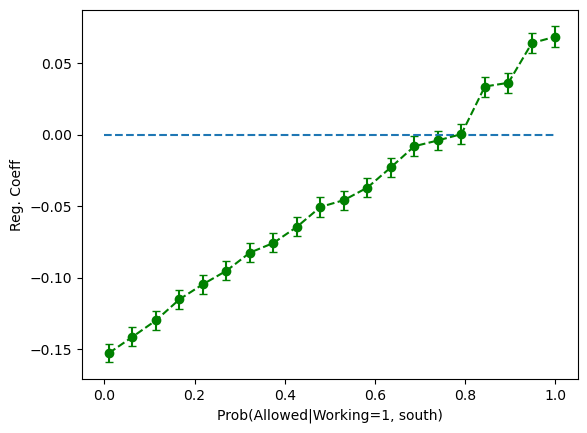

In [144]:
plt.errorbar(x=P, y=Est, yerr=Err, capsize=3, fmt='g--o')
plt.hlines(y=0.0, xmin=-0.0, xmax=1.0, linestyles="--")
plt.xlabel('Prob(Allowed|Working=1, south)')
plt.ylabel('Reg. Coeff')
# plt.legend()
plt.show()

In [17]:
Est = [0]*20
Err = [0]*20
for i in range(10):
    Est = [x+y for x,y in zip(Est, est[i])]
    Err = [x+y for x,y in zip(Err, err[i])]
Est = [e/10 for e in Est]
Err = [e/10 for e in Err]

In [18]:
df_reg = copy.deepcopy(df)
df_reg = df_reg[(df_reg["north"] == 1) | (df_reg["north"] == 0)]

P = np.linspace(0.01,1.0,20)
df_estimates = pd.DataFrame()
est = []
err = []
for i in range(30):
    print(i)
    E = []
    Er = []
    for p in P:    
        df_reg["allowed"] = None
        df_reg.loc[df_reg["GR49"] == "No 0", "allowed"] = 0
        df_reg.loc[df_reg["GR49"] == "Yes 1", "allowed"] = 1

        bit_arr_north = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),:].shape[0]) <= np.random.uniform(p,1)
        bit_arr_south = np.random.uniform(0,1,df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),:].shape[0]) <= p
        int_arr_north = [int(b) for b in bit_arr_north]
        int_arr_south = [int(b) for b in bit_arr_south]
        df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 1),"allowed"] = int_arr_north
        df_reg.loc[(df_reg["GR49"].isna()) & (df_reg["north"] == 0),"allowed"] = int_arr_south
        X = df_reg["allowed"].astype(float)
        X = sm.add_constant(X)
        y = df_reg["working"].astype(float)
        model = sm.OLS(y, X).fit()
        e = model.params["allowed"]
        gap = model.conf_int().loc["allowed"][1] - model.params["allowed"]
        E.append(e)
        Er.append(gap)
    est.append(E)
    err.append(Er)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


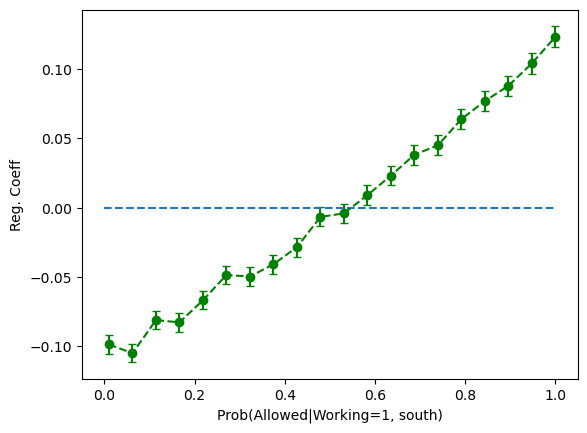

In [19]:
plt.errorbar(x=P, y=Est, yerr=Err, capsize=3, fmt='g--o')
plt.hlines(y=0.0, xmin=-0.0, xmax=1.0, linestyles="--")
plt.xlabel('Prob(Allowed|Working=1, south)')
plt.ylabel('Reg. Coeff')
# plt.legend()
plt.show()